# BTC REGRESSION PREDICTOR

Is it possible to use just raw price data to predict the upcoming price of bitcoin? That is the question I am looking to answer in this notebook. The plan is<br>
to try calculate features from only the date, high, low, open, close and volume for the last 1000 days of price action.

In [964]:
# Import statements

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

In [39]:
# Load our csv as a pandas dataframe
btc = pd.read_csv("BTCUSDT-D.csv")

In [41]:
# Have a squizz at the data
btc.head()

,date,time,open,high,low,close,volume
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382


We have to clean the date column up and split the string apart to only contain the day of the week as my idea is to use that to find a potential pattern <br>
in the price. I think that month in collaboration with day of the week might be handy too but im unsure... So for now we will just try day of the week and <br>
keep months in our back pocket

## Transform the data column, creating features

#### Adding days of the week

In [46]:
# Create a list to hold the days of the week
days = []

# Iterate over each date in the data column
for date in btc["date"]:
    # Split the string on the hypphens and take the first string (The abbrivated day)
    day = date.split("-")[0]
    # append the day to the list
    days.append(day)

# Create the new column for our dataframe containing the days of the week
btc["day"] = days
btc.head()

,date,time,open,high,low,close,volume,day
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon


### Calculate features

In [49]:
# Creates a list out of a given column

def create_list(column):
    """
    Takes a pandas column and iterates over it's content appending each
    row to a list and than returns that list
    :Params: coloumn - a pandas column
    :Return: ls - a list of all values in that column
    """
    
    ls = []
    
    for row in column:
        ls.append(row)
    return ls

#### Calculating percentage change

In [52]:
# Createa list of all open values
opens = btc["open"]

# Create a list of all close values
closes = btc["close"]


# Iterate through both lists of values and calculate the change from open to close price, append it to a list
changes = []
for idx in range(len(opens)):
    change = round((closes[idx] - opens[idx]) / opens[idx] * 100, 2)
    changes.append(change)

# Add the column to the data
btc["change"] = changes
btc.head()

,date,time,open,high,low,close,volume,day,change
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11


#### Calculating high to low differences

In [55]:
# Creates lists for the highs and the lows
highs = create_list(btc["high"])
lows = create_list(btc["low"])

# Create two features calculating the difference between the highs and the lows and the closes
high_to_close = []
low_to_close = []
high_to_low = []
for idx in range(len(closes)):
    high_to_close.append(round((highs[idx] - closes[idx]) / closes[idx] * 100, 2))
    low_to_close.append(round((closes[idx] - lows[idx]) / closes[idx] * 100, 2))
    high_to_low.append(round((highs[idx] - lows[idx]) / highs[idx] * 100, 2))
    
# Add our new features to the dataframe
btc["high_to_close"] = high_to_close
btc["low_to_close"] = low_to_close
btc["high_to_low"] = high_to_low
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49,1.26,5.44,6.61
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02,2.35,0.75,3.04
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75,1.47,0.61,2.05
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71,1.05,2.92,3.92
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11,2.79,0.48,3.18


#### Adding long an short labels

In [58]:
directions = []

for row in changes:
    if row >= 0:
        directions.append("long")
    else: 
        directions.append("short")

btc["direction"] = directions
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11,2.79,0.48,3.18,short


#### Creating a new dataframe on a subset of features

In [61]:
# Creating a smaller dataframe out of only a few features to test some ideas on
btc_features = btc.drop(["date", "time", "open", "high", "low", "close"], axis = 1)
btc_features.head()

,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,1765283382,Mon,-0.11,2.79,0.48,3.18,short


For now we have calculated only the day to day change, and the difference in the daily high and low from the close. I'm very skeptical of how this <br>
is going to work, so I first just want to see if I can get any results before putting anymore effort into this idea. I made a smaller subset of <br>
features in a new dataframe, lets go ahead and run through some workflow with them.

## Machine Learning/Big Data/Python/Collaboration..... workflow

### Attempt 1

In [66]:
btc_features.head()

,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,1765283382,Mon,-0.11,2.79,0.48,3.18,short


In [68]:
# Transform our days using a labelencoder
day_encoder = LabelEncoder()
days = day_encoder.fit_transform(btc_features["day"])

dir_encoder = LabelEncoder()
direction = dir_encoder.fit_transform(btc_features["direction"])

# dir_encoder.classes_
btc_features["days"] = days
# btc_features.head()

In [70]:
# drop all features we don't want in our X set of data
X = btc_features.drop(["day", "change", "direction"], axis = 1)
X.head()

,volume,high_to_close,low_to_close,high_to_low,days
0,2246508966,1.26,5.44,6.61,4
1,1837726929,2.35,0.75,3.04,0
2,1147589024,1.47,0.61,2.05,2
3,1676805639,1.05,2.92,3.92,3
4,1765283382,2.79,0.48,3.18,1


In [72]:
# Split the testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, direction)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check it was transformed into an array by proxy of data scaling
# X_train

In [74]:
# Creating some classifiers to test some ideas on
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

# Getting the f1 scores for the classifiers
rnd_score = cross_val_score(rnd_clf, X_train, y_train, cv = 10, scoring="f1_macro").mean()
print(rnd_score)

knn_score = cross_val_score(knn_clf, X_train, y_train, cv = 10, scoring="f1_macro").mean()
print(knn_score)


0.8118481066501113
0.7784266081100086


Honestly, not terrible scores.... I feel like im missing something though.... like it's just randomly guessing and hitting this number... how does this help me in what im <br>
trying to do anyway? How can I use a classifier that apparently can predict with 80% accuracy if you should long or short the market... but not in the future, on provided <br>
data of the day in the past? I dont think this does help me... I know classification isnt for price prediction but I had an idea that it could classifier what to do on a <br>
given day, but seeing this now, I dont think it can help me.

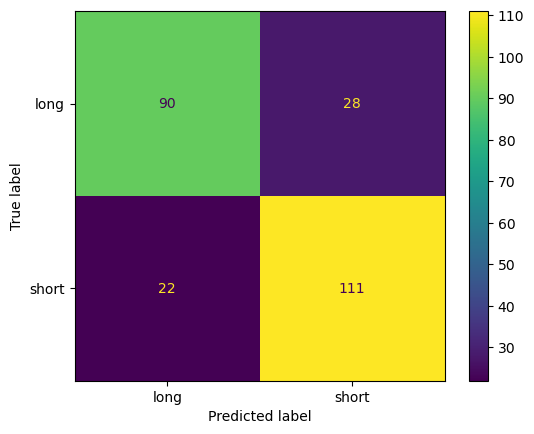

In [76]:
# Fit the rando to print out a confusion matrix to see what's going on with it's predictions
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)
f1_score(y_test, y_pred)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels= dir_encoder.classes_)

In [77]:
# Print out what the rando values most
for name, score in zip(X.columns, rnd_clf.feature_importances_):
    print(name, score)

volume 0.13145648527006765
high_to_close 0.32831654335423716
low_to_close 0.31782476568991996
high_to_low 0.1713616134252412
days 0.051040592260534035


Hmm, the fact that it likes the high and the low from the close the most is absolutely useless... maybe I should try close, volume and day only actually... the other metrics<br>
are useless because they would need to occur for me to prompt the classifier with a prediction... same what change and volume, but perhaps it will train harder on the day.. <br>
the day is the key, if I can prompt the classifier with the day of the week and it can respond with what to do.... that would be interesting to build a bot around using the <br>
highs and the lows are stops and targets.

In [79]:
# # Testing error on a randoregressor... pretty useless, just curious
# rnd_reg = RandomForestRegressor()

# score = cross_val_score(rnd_reg, X_train, y_train, scoring = "neg_mean_squared_error")
# score.mean()
# # import sklearn
# # sklearn.metrics.get_scorer_names()

In [80]:
# Printing out all the average stats for each day and then inputing them into a prediction to see what I get

# Values to hold the stats
change = 0
high = 0
low = 0
mag = 0
vol = 0
divisor = 0

# Creating a set of days, using set for no duplicates
all_days = set()
for day in btc["day"]:
    all_days.add(day)

# Iterating over every day
for day in all_days:
    # Iterating over every row
    for row in range(len(btc)):
        # If the day for the loop matches the day in the row, add all the metrics to their scores
        if btc["day"][row] == day:
            change += btc["change"][row]
            high += btc["high_to_close"][row]
            low += btc["low_to_close"][row]
            mag += btc["high_to_low"][row]
            vol += btc["volume"][row]
            divisor += 1
    # Display the metrics
    print(f"{day} change: {round(change / divisor,4)}\tHigh: {round(high / divisor,4)}\tLow: {round(low / divisor,4)}\tMag: {round(mag / divisor,4)}\tVolume: {round(vol / divisor,4)}")

Sun change: 0.0987	High: 1.5603	Low: 1.5119	Mag: 3.0142	Volume: 2882080575.2867
Wed change: 0.1132	High: 2.0197	Low: 1.9963	Mag: 3.9103	Volume: 4304116845.6643
Tue change: 0.0802	High: 2.1096	Low: 2.1068	Mag: 4.0968	Volume: 4746760434.8858
Mon change: 0.1584	High: 2.1633	Low: 2.2679	Mag: 4.2999	Volume: 4941096851.5105
Thu change: 0.1044	High: 2.2054	Low: 2.2714	Mag: 4.3433	Volume: 5012882626.5489
Sat change: 0.0887	High: 2.0426	Low: 2.1053	Mag: 4.0281	Volume: 4591507482.2782
Fri change: 0.0649	High: 2.0848	Low: 2.1469	Mag: 4.1087	Volume: 4698049690.8144


In [81]:
# Running a predict on the rando, values to pass into the list are: vol, high, low, mag, day. In that order
y_pred = rnd_clf.predict([[0, 2.3789, 2.2858, 0, 4]])
y_pred

# day_encoder.classes_

array([1])

### Attempt 2

This time ill try with only the change, day and volume.

In [84]:
# def pipline(X_set, y_set):

X = btc.drop(["date", "time", "open", "high", "low", "close", "day", "high_to_close", "low_to_close", "high_to_low", "direction"], axis = 1)
X["days"] = days

X_train, X_test, y_train, y_test = train_test_split(X, direction)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
rando2 = RandomForestClassifier()

score2 = cross_val_score(rando2, X_train, y_train, cv = 10, scoring = "f1_macro")
score2.mean()

0.9986657178438001

Again, I smell bullshit... probably because it is 100% using change to define what to do which literally is telling it if it was an iup or down day

In [87]:
rando2 = rando2.fit(X_train, y_train)

for name, score in zip(X.columns, rando2.feature_importances_):
    print(name, score)

volume 0.026706310106653117
change 0.9673420614808699
days 0.0059516284124769975


Yeah so this line of thought is completely pointless, im going about everything wrong, or this just isn't possible doing it the way I am doing it. I wish I could get it to classifier<br>
a percent up or down, but that also makes no sense... None of this makes sense, and I know that, I was just trying to see what I could squeeze out of price only... silly idea.

### Attempt 3

Ok I will try one last thing..., it makes no sense, but I will make the changes the labels and use the days to predict.... wild idea I know... I must exhust everything so I stop<br>
thinking that I have missed something

In [92]:
X = btc.drop(["date", "time", "open", "high", "low", "close", "day", "change", "high_to_close", "low_to_close", "high_to_low", "direction"], axis = 1)
X["days"] = days
y = [int(i) for i in btc.change]

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [93]:
rando2 = RandomForestClassifier()

score2 = cross_val_score(rando2, X_train, y_train, cv = 10, scoring = "f1_macro")
score2.mean()



/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.06552099007298981

That is hilarious.... 6% hitrate... gonna need some tight risk management to pull this stategy off.... I need to go back to the drawing board and think of some external features <br>
to add, or some lagging indicators with price that has a shot of forward predicting the price if im to continue with this project as it is.

In [95]:
btc.head()

,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low,direction
0,Thu-23-Dec-21,00:00:00,48610,51432,48030,50794,2246508966,Thu,4.49,1.26,5.44,6.61,long
1,Fri-24-Dec-21,00:00:00,50794,51980,50402,50785,1837726929,Fri,-0.02,2.35,0.75,3.04,short
2,Sat-25-Dec-21,00:00:00,50785,51149,50100,50406,1147589024,Sat,-0.75,1.47,0.61,2.05,short
3,Sun-26-Dec-21,00:00:00,50406,51294,49283,50763,1676805639,Sun,0.71,1.05,2.92,3.92,long
4,Mon-27-Dec-21,00:00:00,50763,52119,50464,50706,1765283382,Mon,-0.11,2.79,0.48,3.18,short


In [96]:
month = []

for row in btc["date"]:
    month.append(row.split("-")[2])


In [97]:
month_encoder = LabelEncoder()
month = month_encoder.fit_transform(month)
btc["month"] = month

In [99]:
X = btc.drop(["date", "time", "open", "high", "low", "close", "day", "change", "high_to_close", "low_to_close", "high_to_low", "direction"], axis = 1)
X["days"] = days
y = [int(i) for i in btc.change]

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [100]:
rando4 = RandomForestClassifier()

score4 = cross_val_score(rando4, X_train, y_train, cv = 10, scoring = "f1_macro")
score4.mean()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.07423765636806867

Ok sorry, had to try adding in months and seeing what happens... what does it value btw?

In [106]:
rando4 = rando4.fit(X_train, y_train)

for name, score in zip(X.columns, rando4.feature_importances_):
    print(name, score)

volume 0.6807755610588081
month 0.1969890076989397
days 0.12223543124225211


### Attempt ∞

In [515]:
def rolling_avg(column, length):
    """
    Calculates the moving average of length (length) on the series (column) passed
    into the function
    Params
    column - the string name of a pandas column from your dataset
    length - an int the length of the moving average
    """
    rolling_avg = btc[column].rolling(length)

    change_avgs = []

    for line in rolling_avg:
        tot = 0
        for l in line:
            tot += l
        avg = tot / len(line)
        change_avgs.append(round(avg,6))

    # change_avgs.pop(len(change_avgs)-1)
    return change_avgs



In [761]:
def augment_columns(column):
    ls_changes = [0]
    
    for change in btc[column]:
        ls_changes.append(change)
    
    ls_changes.pop(len(ls_changes)-1)
    return ls_changes

In [771]:
# Creating a smaller dataframe out of only a few features to test some ideas on
btc_features = btc.drop(["date", "time", "open", "high", "low", "close"], axis = 1)
btc_features.head()

,volume,day,change,high_to_close,low_to_close,high_to_low,direction,month
0,2246508966,Thu,4.49,1.26,5.44,6.61,long,2
1,1837726929,Fri,-0.02,2.35,0.75,3.04,short,2
2,1147589024,Sat,-0.75,1.47,0.61,2.05,short,2
3,1676805639,Sun,0.71,1.05,2.92,3.92,long,2
4,1765283382,Mon,-0.11,2.79,0.48,3.18,short,2


In [1816]:
# Transform our days using a labelencoder
day_encoder = LabelEncoder()
days = day_encoder.fit_transform(btc_features["day"])

direction_encoder = LabelEncoder()
direction = dir_encoder.fit_transform(btc_features["direction"])
# dir_encoder.classes_

In [2084]:
# Create a new Dataframe for attempt ∞
X = pd.DataFrame()

# Add days as a column in our dataframe
# X["days"] = days

# Assign short and long lengths for moving averages
short_length = 3
long_length = 10

# Add moving averages to our dataframe
X["chang_avg_short"] = rolling_avg("change", short_length)
# X["high_avg_short"] = rolling_avg("high_to_close",short_length)
# X["low_avg_short"] = rolling_avg("low_to_close",short_length)
# X["mag_avg_short"] = rolling_avg("high_to_low",short_length)

# X["chang_avg_long"] = rolling_avg("change",long_length)
# X["high_avg_long"] = rolling_avg("high_to_close",long_length)
# X["low_avg_long"] = rolling_avg("low_to_close",long_length)
# X["mag_avg_long"] = rolling_avg("high_to_low",long_length)

# Add the augmented versions of high, low, change, aguemented by one day, therefore they are the previous days values
X["new_changes"] = augment_columns("change")
# X["new_highs"] = augment_columns("high_to_close")
# X["new_lows"] = augment_columns("low_to_close")

# Inspect what we have done
X.head()

,chang_avg_short,new_changes
0,4.490,0.00
1,2.235,4.49
2,1.240,-0.02
3,-0.020,-0.75
4,-0.050,0.71


In [2086]:
# Split the data for training
X_train, X_test, y_train, y_test = train_test_split(X, direction, random_state = 42)

# Scale the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [2113]:
### Create a randomForest and validate it's score
# rnd_clf = RandomForestClassifier(random_state = 42)

# rnd_clf_score = cross_val_score(rnd_clf, X_train, y_train, cv = 10, scoring = "f1_macro")
# print(rnd_clf_score.mean())

# ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 200, algorithm="SAMME.R", learning_rate=0.5)

# ada_clf_score = cross_val_score(ada_clf, X_train, y_train, cv = 10, scoring = "f1_macro")
# print(ada_clf_score.mean())

# gbc_clf = GradientBoostingClassifier(max_depth = 2, n_estimators = 3, learning_rate = 1.0)

# gbc_clf_score = cross_val_score(gbc_clf, X_train, y_train, cv = 10, scoring = "f1_macro")
# print(gbc_clf_score.mean())

sgd_clf = SGDClassifier(alpha=0.01, tol=0.001,random_state=42)

sgd_clf_score = cross_val_score(sgd_clf, X_train, y_train, cv = 10, scoring = "accuracy")
print(sgd_clf_score.mean())

0.747017543859649


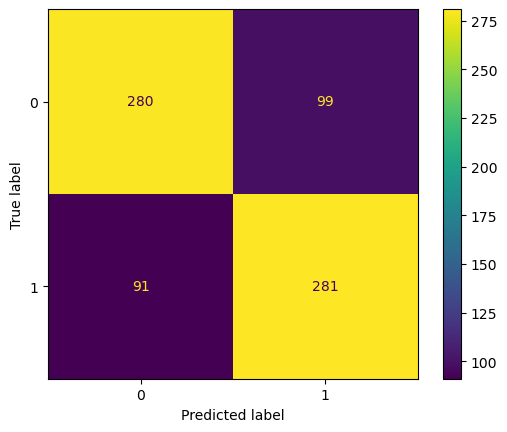

In [2089]:
# rnd_clf.fit(X_train, y_train)
# y_pred = rnd_clf.predict(X_test)
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

sgd_clf.fit(X_train, y_train)
y_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 10)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)

In [2090]:
print(X.tail())
btc.tail(7)

      chang_avg_short  new_changes
997          0.596667        -0.82
998         -1.273333        -1.45
999          0.196667        -1.55
1000         0.656667         3.59
1001         1.810000        -0.07


,date,time,open,high,low,close,volume,day,change,high_to_close,low_to_close,high_to_low,direction,month
995,Fri-13-Sep-24,00:00:00,58105,60624,57579,60466,7579852994,Fri,4.06,0.26,4.77,5.02,long,11
996,Sat-14-Sep-24,00:00:00,60466,60584,59358,59968,3092231738,Sat,-0.82,1.03,1.02,2.02,short,11
997,Sun-15-Sep-24,00:00:00,59968,60393,58652,59101,3763712483,Sun,-1.45,2.19,0.76,2.88,short,11
998,Mon-16-Sep-24,00:00:00,59101,59182,57450,58185,7324801553,Mon,-1.55,1.71,1.26,2.93,short,11
999,Tue-17-Sep-24,00:00:00,58185,61330,57568,60275,9513245410,Tue,3.59,1.75,4.49,6.13,long,11
1000,Wed-18-Sep-24,00:00:00,60275,60747,59835,60231,1349677844,Wed,-0.07,0.86,0.66,1.50,short,11
1001,Thu-19-Sep-24,00:00:00,61744,63856,61524,62923,9254066053,Thu,1.91,1.48,2.22,3.65,long,11


In [2091]:

# Percent change is taking the moving average for a longer period than what is being used as a feature in the classifier
# and inputing it as one of the parameters for predictioin. The reason we need this is because this sgd model is using
# The last three day moving average as a feature yet we dont have the current days % change moving average until the day
# ends, therefore we need to source a different average that should be close to the 3 day, but more general as to add as
# little bias as possible to the predict.... that's what this is.
percent_change = rolling_avg("change",long_length)[len(rolling_avg("change",long_length))-1]

# Predicting the current days market direction, first parameter explained above, second is what the daily closed the morning 
# of this day.
trade = sgd_clf.predict([[percent_change, 1.91]])

trade = dir_encoder.classes_[trade[0]]
# day_encoder.classes_
trade

'short'

In [2093]:
# Calculate a 7 day avg of change and try classify on that
# Figure out a way to make a regressor that we put in a pervious days or weeks set of details or avgs 
# and have it output a prediction on % change the next day

In [2094]:
# rnd_clf = rnd_clf.fit(X_train, y_train)

# for name, score in zip(X.columns, rnd_clf.feature_importances_):
#     print(name, score)

In [2097]:
# Figures out what the trade for the day is

high = rolling_avg("high_to_close",short_length)
low = rolling_avg("low_to_close",short_length)

high = high[len(high)-1]
low = low[len(low)-1]

target = 0
stop = 0
entry = btc["close"][len(btc)-1]
if trade == "long":
    target = high /100 * entry + entry
    stop = entry - (low /100 * entry)
else:
    target = entry - (low /100 * entry)
    stop = high /100 * entry + entry

print(f"Today's trade is a {trade} with an entry at {entry} a stop at {round(stop)} and a target of {round(target)}")

Today's trade is a short with an entry at 62923 a stop at 63781 and a target of 61377


This is kinda at a point where I either build a bot to execute trades on it or bin this plan and go do some neural network stuff for this problem

In [2102]:

X["chang_avg_long"] = rolling_avg("change",long_length)
X["direction"] = direction
X

,chang_avg_short,new_changes,chang_avg_long,direction
0,4.490000,0.00,4.4900,0
1,2.235000,4.49,2.2350,1
2,1.240000,-0.02,1.2400,1
3,-0.020000,-0.75,1.1075,0
4,-0.050000,0.71,0.8640,1
...,...,...,...,...
997,0.596667,-0.82,0.5390,1
998,-1.273333,-1.45,0.7790,1
999,0.196667,-1.55,1.1000,0
1000,0.656667,3.59,0.9620,1


In [2103]:
correct = 0
all = 0
for row in range(len(X)):
    prediction = sgd_clf.predict([[X["chang_avg_long"][row], btc["change"][row]]])

    if prediction[0] == X["direction"][row]:
        correct += 1
    all += 1

print(all, correct)

1002 163


Ok this little experiment kinda put the nail in the coffin.... right now it is meant to have 74% accuracy, but when calling predict on the entire set and<br>
passing in what would be the correct second parameter of the next days change % and the first parameter of a slightly longer caalculated average of change<br>
we only are able to get 163  out of 1000 trades right... 16% is not good at all and something doesn't seem right for a classifier that can get 75% f1_score?